# A Grid class to deal with any finite difference model grid
*Prof. dr.ir.T.N.Olsthoorn*

*Heemstede, Sept. 2016*

## Using a Grid class to handle spatial information regarding the grid

As we saw we often have to compute values of the grid, like the `xm`, `dx`, `Nx`, `Ny`, `shape` etc. A much better, more convenient and far less error-prone method of dealing with anything that has to do with the spacial dimensions of the finite difference grid is to define a Grid class, whose instances are created with the grid coordinates like so

    gr = Grid(x, y, z)

after which any spatial information can be obtained from the actual Grid instanceuse, called gr in this example.

Requesting values then work like this:

    gr.Nx       # int, len(x)-1
    gr.shape    # tuple (Nt, Nx, Nz)
    gr.xm       # ndarray, (len(x)-1
    gr.Xm       # ndarray, (Ny, Nx) of x-coordinates of cell centers
    gr.XM       # ndarray, (Ny, Nx, Nz) of x-coordinates of cell centers
    gr.YM       # ndarray, (Ny, Nx, Nz) of y-coordinates of cell centers
    gr.xm[3:10] # indexing gr.xm
    gr.shape    # tuple, (Ny, Nx, Nz)
    gr.area     # scalar, total area of the model
    gr.Area     # ndarray, (Ny, Nx)
    gr.volume   # scalar total volume of the model
    gr.Volume   # ndarray, (Ny, Nx, Nz)

A large number of spacial or grid-specific variables, in fact, anything that can be computed from the coordinates can then be obtained.

The Grid class will take care of error checking and house-keeping. It can even be told to interpret the grid as
axially symmetric

    gr = Grid(x, y, z, axial=True)

It can guarantee a minimum layer thickness like so

    gr = Grid(x, y, z, min_dz=0.001)
    
No matter if z used to invoke the Grid was specified as a vector telling the elevation of the tops and bottoms of uniform layers, or if z is a full-fledged 3D ndarray telling the top and bottom of all cells, Grid will handle it, in any case yielding a full 3D array of tops and bottoms when requested

    gr.Z # full 3D array: shape (Ny, Nx, Nz+1)

and any other like grid related quantities that one may think of.

All grid related information is then contained in the grid object, where the z needs not be limited to a vector but may be a full 3D array of the tops and bottoms of all cells, so that each cell column can have elevations different from its neighbors. This approach is definitely much more flexible. Also, the grid can carry out all necessary error checking behing the scene which is effective as well.

The Grid class also has methods,like

    A = gr.const(v)
    
This generates a ndarray of the size of the model with all values `v` if `v` is a scalar or with
the values cells in layer `i` the value `v[i]` if `v` is a vector of length `gr.Nz`.

    gr.plot(linespec)

will plot itself using the specified linespec, i.e. combination of color and linetype like used in ``matplotilb.plot``.

Additionally, other functions like `fdm3` can be adapted to simply accept a `Grid` object as input instead of individual `x`, `y` and `z` coordinates. This requires less preparation and less clutting insize fdm3, while error checking then is delegated to the Grid object.

You can learn about the Grid class by introspection or by simply loading it in an editor and studying how it was implemented. Simply typing

    Grid?

Provides the help from its docstring.


## Grid-adapted model fdm3

The module fdm_b of the previous chapter contains the functions `unique()`, `quivdata()` and `fdm3`. This model is copied below but only the functions `fdm3` and `quivdata` have been adapted to deal with the grid object for its grid information.

The new module will be save as ``fdm_c.py``

In [1]:
%%writefile fdm_c.py

import numpy as np
import pdb
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve # to use its short name
from collections import namedtuple

class InputError(Exception):
    pass

def quivdata(Out, gr, iz=0):
    """Returns coordinates and velocity components to show velocity with quiver
    
    Compute arrays to display velocity vectors using matplotlib's quiver.
    The quiver is always drawn in the xy-plane for a specific layer. Default iz=0
    
    Parameters
    ----------
    `Out` : namedtuple holding arrays `Qx`, `Qy`, `Qz` as defined in `fdm3`
        `Qx` : ndarray, shape: (Ny, Nx-1, Nz), [L3/T]
            Interfacial flows in finite difference model in x-direction from `fdm3'
        `Qy` : ndarray, shape: (Ny-1, Nx, Nz), [L3/T]
            Interfacial flows in finite difference model in y-direction from `fdm3`
        `Qz` : ndarray, shape: (Ny, Nx, Nz-1), [L3/T]
            Interfacial flows in finite difference model in z-direction from `fdm3`            
    `gr` : `grid_object` generated by Grid
    `iz` : int [-]
            iz is the number of the layer for which the data are requested,
            and all output arrays will be 2D for that layer.
            if iz==None, then all outputs will be full 3D arrays and cover all layers
            simultaneously

    Returns
    -------
    `Xm` : ndarray, shape: (Ny, Nx, Nz), [L]
        x-coordinates of cell centers
    `Ym` : ndarray, shape: (Ny, Nx, Nz), [L]
        y-coodinates of cell centers
    `ZM` : ndarray, shape: (Ny, Nx, Nz), [L]
        `z`-coordinates at cell centers
    `U` : ndarray, shape: (Ny, Nx, Nz), [L3/d]
        Flow in `x`-direction at cell centers
    `V` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        Flow in `y`-direction at cell centers
    `W` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        Flow in `z`-direction at cell centers.
    
    """
    
    X, Y = np.meshgrid(gr.xm, gr.ym) # coordinates of cell centers
    
    shp = (gr.Ny, gr.Nx) # 2D tuple to select a single layer
    
    # Flows at cell centers
    U = np.concatenate((Out.Qx[:,0,iz].reshape((gr.Ny,1,1)), \
                        0.5 * (Out.Qx[:,:-1,iz].reshape((gr.Ny,gr.Nx-2,1)) +\
                               Out.Qx[:, 1:,iz].reshape((gr.Ny,gr.Nx-2,1))), \
                        Out.Qx[:,-1,iz].reshape((gr.Ny,1,1))), axis=1).reshape(shp)
    V = np.concatenate((Out.Qy[0, :,iz].reshape((1,gr.Nx,1)), \
                        0.5 * (Out.Qy[:-1,:,iz].reshape((gr.Ny-2,gr.Nx,1)) +\
                               Out.Qy[ 1:,:,iz].reshape((gr.Ny-2,gr.Nx,1))), \
                        Out.Qy[-1,:,iz].reshape((1,gr.Nx,1))), axis=0).reshape(shp)
    return X, Y, U, V


def unique(x, tol=0.0001):
    """return sorted unique values of x, keeping ascending or descending direction"""
    if x[0]>x[-1]:  # vector is reversed
        x = np.sort(x)[::-1]  # sort and reverse
        return x[np.hstack((np.diff(x) < -tol, True))]
    else:
        x = np.sort(x)
        return x[np.hstack((np.diff(x) > +tol, True))]

    
def fdm3(gr, kx, ky, kz, FQ, HI, IBOUND):
    '''Steady state 3D Finite Difference Model returning computed heads and flows.
        
    Heads and flows are returned as 3D arrays as specified under output parmeters.
    
    Parameters
    ----------
    'gr' : `grid_object`, generated by gr = Grid(x, y, z, ..)
    `kx`, `ky`, `kz` : ndarray, shape: (Ny, Nx, Nz), [L/T]
        hydraulic conductivities along the three axes, 3D arrays.
    `FQ` : ndarray, shape: (Ny, Nx, Nz), [L3/T]
        prescrived cell flows (injection positive, zero of no inflow/outflow)
    `IH` : ndarray, shape: (Ny, Nx, Nz), [L]
        initial heads. `IH` has the prescribed heads for the cells with prescribed head.
    `IBOUND` : ndarray, shape: (Ny, Nx, Nz) of int
        boundary array like in MODFLOW with values denoting
        * IBOUND>0  the head in the corresponding cells will be computed
        * IBOUND=0  cells are inactive, will be given value NaN
        * IBOUND<0  coresponding cells have prescribed head
    
    outputs
    -------    
    `Out` : namedtuple containing heads and flows:
        `Out.Phi` : ndarray, shape: (Ny, Nx, Nz), [L3/T] 
            computed heads. Inactive cells will have NaNs
        `Out.Q`   : ndarray, shape: (Ny, Nx, Nz), [L3/T]
            net inflow in all cells, inactive cells have 0
        `Out.Qx   : ndarray, shape: (Ny, Nx-1, Nz), [L3/T] 
            intercell flows in x-direction (parallel to the rows)
        `Out.Qy`  : ndarray, shape: (Ny-1, Nx, Nz), [L3/T] 
            intercell flows in y-direction (parallel to the columns)
        `Out.Qz`  : ndarray, shape: (Ny, Nx, Nz-1), [L3/T] 
            intercell flows in z-direction (vertially upward postitive)
        the 3D array with the final heads with `NaN` at inactive cells.
    
    TO 160905
    '''

    # define the named tuple to hold all the output of the model fdm3
    Out = namedtuple('Out',['Phi', 'Q', 'Qx', 'Qy', 'Qz'])
    Out.__doc__ = """fdm3 output, <namedtuple>, containing fields Phi, Qx, Qy and Qz\n \
                    Use Out.Phi, Out.Q, Out.Qx, Out.Qy and Out.Qz"""                            
                                
    if kx.shape != gr.shape:
        raise AssertionError("shape of kx {0} differs from that of model {1}".format(kx.shape,SHP))
    if ky.shape != gr.shape:
        raise AssertionError("shape of ky {0} differs from that of model {1}".format(ky.shape,SHP))
    if kz.shape != gr.shape:
        raise AssertionError("shape of kz {0} differs from that of model {1}".format(kz.shape,SHP))
    
    active = (IBOUND>0).reshape(gr.Nod,)  # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(gr.Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND<0).reshape(gr.Nod,)  # boolean vector denoting fixed-head cells

    # reshaping shorthands
    rx = lambda a : np.reshape(a, (1, gr.Nx, 1))
    ry = lambda a : np.reshape(a, (gr.Ny, 1, 1))
    rz = lambda a : np.reshape(a, (1, 1, gr.Nz))
        
    # half cell flow resistances
    Rx = 0.5 * rx(gr.dx) / (ry(gr.dy) * rz(gr.dz)) / kx
    Ry = 0.5 * ry(gr.dy) / (rz(gr.dz) * rx(gr.dx)) / ky
    Rz = 0.5 * rz(gr.dz) / (rx(gr.dx) * ry(gr.dy)) / kz
    
    # set flow resistance in inactive cells to infinite
    Rx = Rx.reshape(gr.Nod,); Rx[inact] = np.Inf; Rx=Rx.reshape(gr.shape)
    Ry = Ry.reshape(gr.Nod,); Ry[inact] = np.Inf; Ry=Ry.reshape(gr.shape)
    Rz = Rz.reshape(gr.Nod,); Rz[inact] = np.Inf; Rz=Rz.reshape(gr.shape)
    
    # conductances between adjacent cells
    Cx = 1 / (Rx[:,:-1,:] + Rx[:,1:,:])
    Cy = 1 / (Ry[:-1,:,:] + Ry[1:,:,:])
    Cz = 1 / (Rz[:,:,:-1] + Rz[:,:,1:])
    
    IE = gr.NOD[:,1:,:]  # east neighbor cell numbers
    IW = gr.NOD[:,:-1,:] # west neighbor cell numbers
    IN = gr.NOD[:-1,:,:] # north neighbor cell numbers
    IS = gr.NOD[1:,:,:]  # south neighbor cell numbers
    IT = gr.NOD[:,:,:-1] # top neighbor cell numbers
    IB = gr.NOD[:,:,1:]  # bottom neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()

    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple
    # also notice that Cij = negative but that Cii will be postive, namely -sum(Cij)
    A = sp.csc_matrix(( -np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                        (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                         np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                      )),(gr.Nod,gr.Nod))
    
    # to use the vector of diagonal values in a call of sp.diags() we need to have it aa a 
    # standard nondimensional numpy vector.
    # To get this:
    # - first turn the matrix obtained by A.sum(axis=1) into a np.array by np.array( .. )
    # - then take the whole column to loose the array orientation (to get a dimensionless numpy vector)
    adiag = np.array(-A.sum(axis=1))[:,0]
    
    Adiag = sp.diags(adiag)  # diagonal matrix with a[i,i]
    
    RHS = FQ.reshape((gr.Nod,1)) - A[:,fxhd].dot(HI.reshape((gr.Nod,1))[fxhd]) # Right-hand side vector
    
    Out.Phi = HI.flatten() # allocate space to store heads
    
    Out.Phi[active] = spsolve( (A+Adiag)[active][:,active] ,RHS[active] ) # solve heads at active locations
    
    # net cell inflow
    Out.Q  = (A+Adiag).dot(Out.Phi).reshape(gr.shape)

    # set inactive cells to NaN
    Out.Phi[inact] = np.NaN # put NaN at inactive locations
    
    # reshape Phi to shape of grid
    Out.Phi = Out.Phi.reshape(gr.shape)
    
    #Flows across cell faces
    Out.Qx =  -np.diff( Out.Phi, axis=1) * Cx
    Out.Qy =  +np.diff( Out.Phi, axis=0) * Cy
    Out.Qz =  +np.diff( Out.Phi, axis=2) * Cz
    
    return Out # all outputs in a named tuple for easy access

Overwriting fdm_c.py


In [2]:
import fdm_c
from importlib import reload
reload(fdm_c)

<module 'fdm_c' from '/Users/Theo/GRWMODELS/Python_projects/FDM_course/fdm_c.py'>

## Example

We use the same 3D example as before but now apply the grid object.

In [9]:
# Make sure that your modules like grid are in the sys.path
import sys

path2modules = './modules/'

if not path2modules in sys.path:
    sys.path.append(path2modules)


In [11]:
reload(mfgrid)

<module 'mfgrid' from '/Users/Theo/GRWMODELS/Python_projects/FDM_course/mfgrid.py'>

In [12]:
gr.z

array([  20.,    0.,  -10., -100.])

<IPython.core.display.Javascript object>


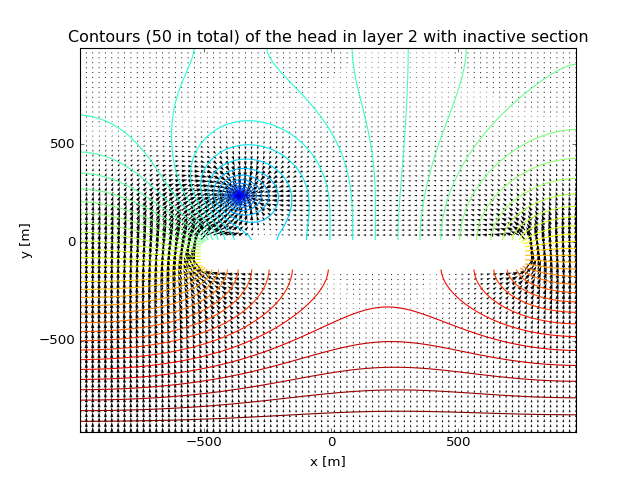

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt # combines namespace of numpy and pyplot

import numpy as np
import mfgrid
Grid = mfgrid.Grid

# specify a rectangular grid
x = np.arange(-1000.,  1000.,  25.)
y = np.arange( 1000., -1000., -25.)
z = np.array([20, 0 ,-10, -100.])

gr = Grid(x, y, z) # generating a grid object for this model

k = 10.0 # m/d uniform conductivity
kx = k * gr.const(k) # using gr.const(value) to generate a full 3D array of the correct shape
ky = k * gr.const(k)
kz = k * gr.const(k)

IBOUND = gr.const(1)
IBOUND[-1,:,:] = -1  # last row of model heads are prescribed
IBOUND[40:45,20:70,:]=0 # inactive

FQ = gr.const(0.)    # all flows zero. Note SHP is the shape of the model grid
FQ[30,25,2] = -1200  # extraction in this cell

HI = gr.const(0.)

Out = fdm_c.fdm3(gr, kx, ky, kz, FQ, HI, IBOUND)

layer = 2 # contours for this layer
nc = 50   # number of contours in total

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title("Contours (%d in total) of the head in layer %d with inactive section" % (nc, layer))
plt.contour(gr.xm, gr.ym, Out.Phi[:,:,layer], nc) # using gr here also

#plt.quiver(X, Y, U, V) # show velocity vectors
#X, Y, U, V = fdm_c.quivdata(Out, gr, iz=0) # use function in fdm_c
X, Y, U, V = gr.quivdata(Out, iz=0) # use method in Grid
plt.quiver(X, Y, U, V)

## Conclusion

Managing and providing spatial information with respect to the grid of our finite difference models can be effectively delegated to a Grid object, which is a instance of the Grid class.

We have adapted our finite differnce model `fmd3` and the function `quivdata` to make use of the grid. We then used the grid to more effectively setup a the same model as before and handle its spatial informaion.

We finally applied the adapte function quivdata to show the quiver. We can alternatively use this function or the method quivdata implemented in the Grid class.